In [53]:
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt 
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS 
import nltk
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
import numpy as np
import scipy as sp
import heapq
from tqdm import tqdm_notebook as tqdm

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LassoCV

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import scale
from sklearn.metrics import roc_auc_score,accuracy_score
from sklearn.model_selection import GridSearchCV
from random import randint 
from sklearn.decomposition import PCA
from sklearn import metrics

from sklearn import tree
from sklearn.utils import shuffle

In [2]:
import tensorflow as tf

print(tf.__version__)

2.0.0


In [3]:
df = pd.read_csv("Reddit_Election_Posts.csv")

In [4]:
def get_date(created):
    return dt.datetime.fromtimestamp(created)

In [5]:
df['url'].astype(str).str[0:]

0        https://www.reddit.com/r/Liberal/comments/9m2d...
1        https://www.reddit.com/r/Liberal/comments/9m2f...
2        https://www.reddit.com/r/Liberal/comments/9m2i...
3        https://www.reddit.com/r/Liberal/comments/9m2k...
4        https://www.reddit.com/r/Liberal/comments/9m3y...
                               ...                        
27825    http://www.openmarket.org/2012/07/10/quotas-li...
27826    http://www.marketplace.org/topics/wealth-pover...
27827    http://www.denverpost.com/politics-national/20...
27828    http://thoughtcatalog.com/2012/american-discor...
27829    https://www.reddit.com/r/moderatepolitics/comm...
Name: url, Length: 27830, dtype: object

In [6]:
#get posted date, add to df
_timestamp = df["created"].apply(get_date)
df = df.assign(timestamp = _timestamp)

#find election year
df['election year']=df['year'].astype(str).str[0:4]

In [7]:
type(str(df['body'][9]))

str

In [8]:
#feature engineering

url_agency = []
title_len = []
body_del = []
body_removed = []
body_len = []

for x in range(0,len(df)):
    #find url agency, i.e. content source
    if "www." in df['url'][x]:
        y=(df['url'][x].find("."))
        z=df['url'][x].find(".",y+1)
        url_agency.append(df['url'][x][y+1:z])
    
    elif "redd.it" in df['url'][x]:
        url_agency.append('reddit')
    elif "https://" in df['url'][x]:
        z=df['url'][x].find(".",8)
        url_agency.append(df['url'][x][8:z])
    else:
        z=df['url'][x].find(".",7)
        url_agency.append(df['url'][x][7:z])
    
    #find length of post title
    title_len.append(len(df['title'][x]))
    
    if "removed" in str(df['body'][x]):
        body_removed.append(1)
    else:
        body_removed.append(0)
        
    if "deleted" in str(df['body'][x]):
        body_del.append(1)
    else:
        body_del.append(0)

       
    body_len.append(len(str(df['body'][x])))


df['url agency']=url_agency
df['title length']=title_len
df['body removed by moderator']=body_removed
df['body deleted by user']=body_del
df['body length']=body_len

In [9]:
df.head(10)

,subreddit,year,title,score,id,url,comms_num,created,body,timestamp,election year,url agency,title length,body removed by moderator,body deleted by user,body length
0,Liberal,2018-11-06,Changing party affiliation in response to Kave...,13,9m2dtt,https://www.reddit.com/r/Liberal/comments/9m2d...,49,1.538914e+09,"Hey everyone,\n\nSo, I've long tried to be the...",2018-10-07 08:03:17,2018,reddit,51,0,0,1815
1,Liberal,2018-11-06,My mother and I have decided to cut off commun...,1,9m2f5d,https://www.reddit.com/r/Liberal/comments/9m2f...,0,1.538914e+09,[removed],2018-10-07 08:09:44,2018,reddit,65,1,0,9
2,Liberal,2018-11-06,What can I do to help?,0,9m2ixb,https://www.reddit.com/r/Liberal/comments/9m2i...,10,1.538915e+09,[deleted],2018-10-07 08:28:44,2018,reddit,22,0,1,9
3,Liberal,2018-11-06,The current World Population is estimated to b...,4,9m2kyh,https://www.reddit.com/r/Liberal/comments/9m2k...,8,1.538916e+09,[deleted],2018-10-07 08:39:28,2018,reddit,145,0,1,9
4,Liberal,2018-11-06,"С кем поведешься, от того и наберешься",1,9m3ygv,https://www.reddit.com/r/Liberal/comments/9m3y...,0,1.538935e+09,[removed],2018-10-07 13:49:12,2018,reddit,38,1,0,9
5,Liberal,2018-11-06,Was the effort of trying to stop Kavanaugh fro...,5,9m48rx,https://www.reddit.com/r/Liberal/comments/9m48...,27,1.538939e+09,[deleted],2018-10-07 14:57:37,2018,reddit,83,0,1,9
6,Liberal,2018-11-06,Can Kavanaugh be impeached?,4,9m5qno,https://www.reddit.com/r/Liberal/comments/9m5q...,21,1.538954e+09,If there's a proper investigation and it's cle...,2018-10-07 19:11:39,2018,reddit,27,0,0,133
7,Liberal,2018-11-06,This will either prove that liberals are the F...,3,9m5xj2,https://www.reddit.com/r/Liberal/comments/9m5x...,0,1.538955e+09,[removed],2018-10-07 19:36:13,2018,reddit,148,1,0,9
8,Liberal,2018-11-06,New Brunswick's 2018 Election - Explanation - ...,1,9m60wu,https://www.youtube.com/watch?v=JhVTRUyZviw,1,1.538956e+09,NaN,2018-10-07 19:48:04,2018,youtube,62,0,0,3
9,Liberal,2018-11-06,"'Let's Do This': After Owning Liberals Today, ...",0,9m62mn,https://townhall.com/tipsheet/mattvespa/2018/1...,0,1.538956e+09,NaN,2018-10-07 19:54:04,2018,townhall,109,0,0,3


In [10]:
df['subreddit'].value_counts()

Conservative        24175
Liberal              2916
moderatepolitics      739
Name: subreddit, dtype: int64

In [11]:
df['election year'].value_counts()

2018    10308
2012     7319
2016     5603
2014     4600
Name: election year, dtype: int64

## Scores and Number of Comments per Post

**Extreme Outlier Note:**
There is an extreme outlier in the conservative thread titled: "Why we won", which happened after the 2016 election. This must have happened late in the evening so that it still technically happened on the election day. 
<br>
Link [here](https://www.reddit.com/r/Conservative/comments/5c3xah/why_we_won/)

<Figure size 1332x756 with 0 Axes>

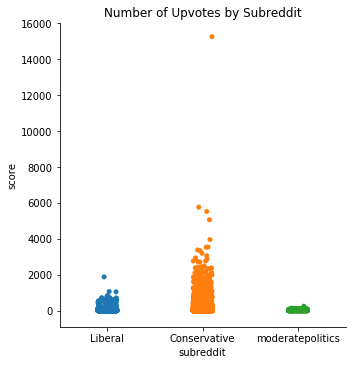

In [12]:
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
sns.catplot(x="subreddit", y="score", data=df);
plt.title("Number of Upvotes by Subreddit")
plt.show()

<Figure size 1332x756 with 0 Axes>

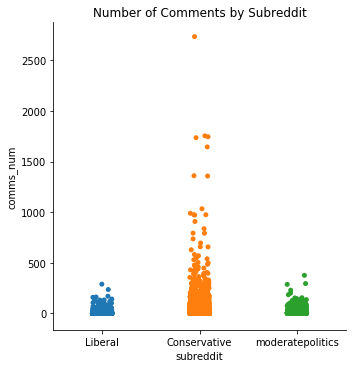

In [13]:
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
sns.catplot(x="subreddit", y="comms_num", data=df);
plt.title("Number of Comments by Subreddit")
plt.show()

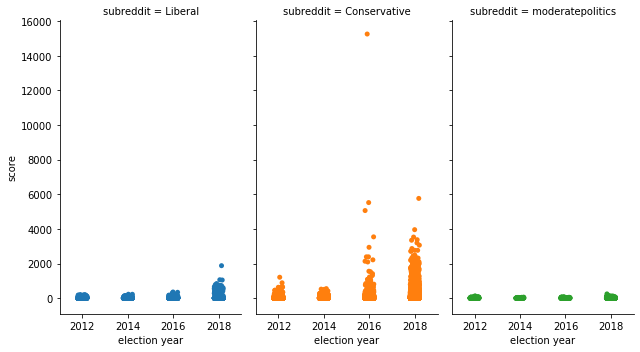

In [14]:
sns.catplot(x="election year", y="score", hue="subreddit",
            col="subreddit", aspect=.6,
             data=df);


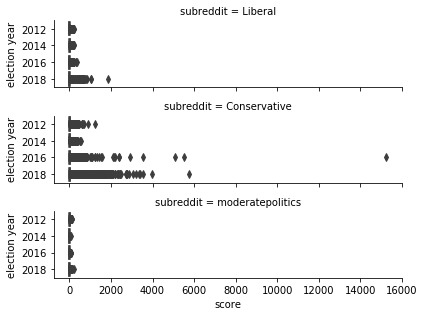

In [15]:
g = sns.catplot(x="score", y="election year", row="subreddit",
                kind="box", orient="h", height=1.5, aspect=4,
                data=df)


## Body Length & Actual Content Per Post

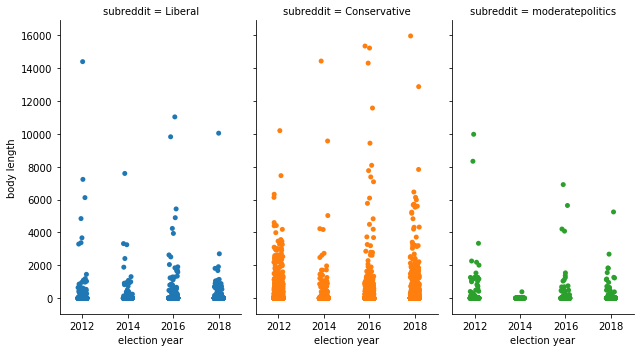

In [16]:
sns.catplot(x="election year", y="body length", hue="subreddit",
            col="subreddit", aspect=.6,
             data=df);



## Overall Trends

#### Posts appear to be up to 300 characters long, which aligns fairly well with twitter specifications

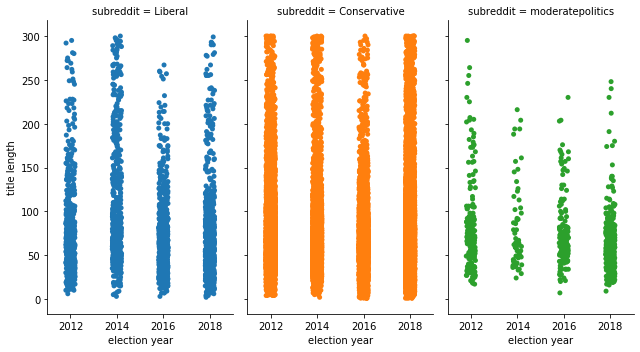

In [17]:
sns.catplot(x="election year", y="title length", hue="subreddit",
            col="subreddit", aspect=.6,
             data=df);



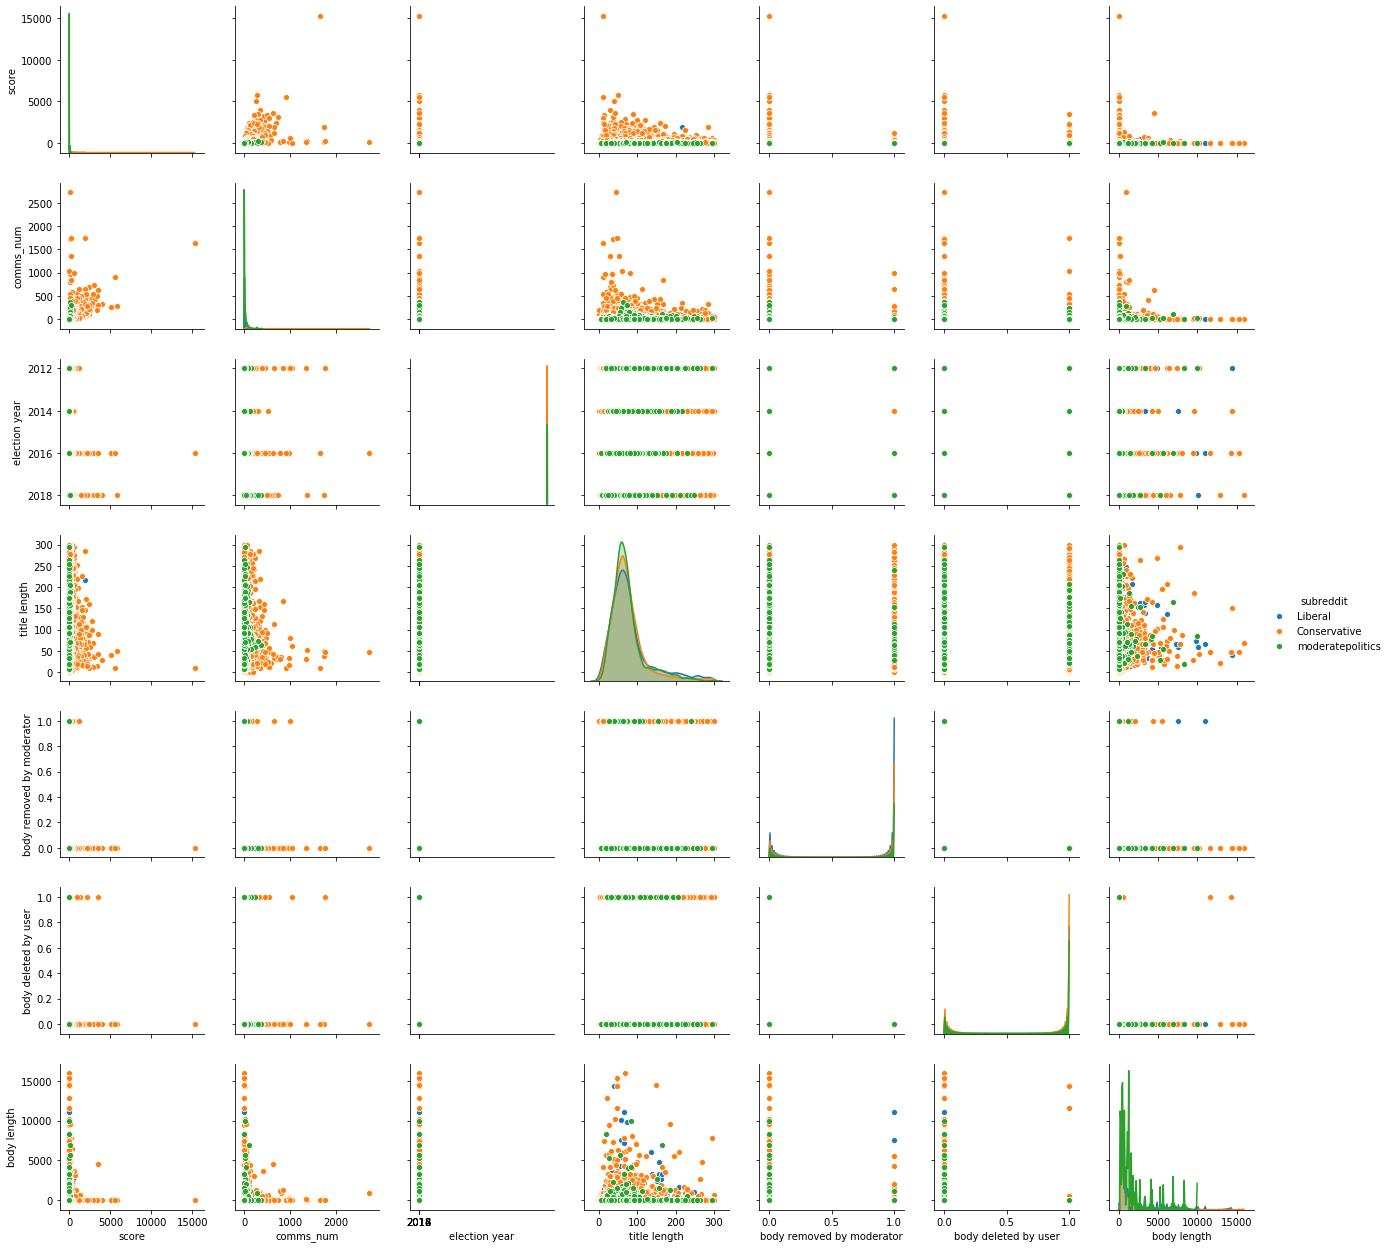

In [18]:
sns.pairplot(data=df.drop(columns=['created']), hue="subreddit");


In [19]:
subreddits = ["Conservative","Liberal","moderatepolitics"]

### News Sources

In [20]:
content_counts = df['url agency'].value_counts()

In [21]:
content_counts[0:30]

reddit                4898
youtube               1394
breitbart              872
i                      602
foxnews                562
youtu                  507
dailycaller            450
nationalreview         441
dailywire              421
thegatewaypundit       393
thehill                383
freebeacon             351
washingtonpost         348
imgur                  330
hotair                 329
nytimes                299
washingtontimes        289
washingtonexaminer     263
townhall               260
politico               247
americanthinker        222
thefederalist          213
twitter                188
nypost                 186
realclearpolitics      186
news                   181
newsbusters            179
m                      157
theblaze               157
pjmedia                155
Name: url agency, dtype: int64

Text(0.5, 0, 'characters')

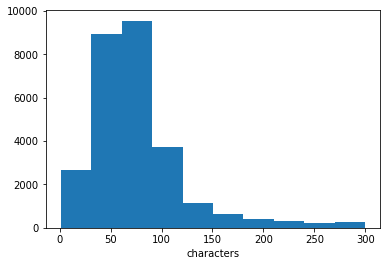

In [22]:
plt.hist(df['title length'])
plt.xlabel('characters')

In [23]:
# def lexical_diversity(text):
#     return len(set(text)) / len(text)
# print('lexical diversity in conservative posts (*100):', lexical_diversity(df_new[df_new['class']=='Conservative'])*100)
# print('lexical diversity in liberal posts (*100):', lexical_diversity(df_new[df_new['class']=='Liberal'])*100)
# print('lexical diversity in moderate posts (*100):', lexical_diversity(df_new[df_new['class']=='moderatepolitics'])*100)
# print('Moderate posts use a more diverse lexicon than the rest')

NameError: name 'df_new' is not defined

# NLTK Analysis

In [24]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to C:\Users\Sebastian
[nltk_data]     Acevedo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [25]:
def stringinize(df):
    comment_words = ' '
    token_list = []
    
    for x in df['title']:

        # typecaste each val to string      
        val = str(x.strip()) 

        # split the value 
        #tokens = val.split() 
        
        #tokenize
        tokens = word_tokenize(x)
        
        # Converts each token into lowercase 
        for i in range(len(tokens)): 
            tokens[i] = tokens[i].lower() 

        for words in tokens: 
            comment_words = comment_words + words + " "
            token_list.append(words)
    
    return comment_words, token_list

In [26]:
# make NLTK dataset for dictionaries with words for each subreddit

word_dict = { "subreddit":[], 
                "comment_words":[], 
                "token_list":[]}

for x in subreddits:
    df_temp = df.loc[df['subreddit']==x]
    
    
    word_dict["subreddit"].append(str(x))
    
    comment_words, token_list = stringinize(df_temp)
    word_dict["comment_words"].append(comment_words)
    word_dict["token_list"].append(token_list)

KeyboardInterrupt: 

In [ ]:
stopwords = set(STOPWORDS)

fig, (ax1, ax2, ax3) = plt.subplots(1,3)

for x, y,z in zip(word_dict['comment_words'], subreddits,[ax1, ax2, ax3]):    
    wordcloud = WordCloud(width = 400, height = 400, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10,
                     collocations = True).generate(x) 
  
    # plot the WordCloud image
    #plt.figure(figsize = (5,5), facecolor = None) 
    z.set_title(str(y) + " Word Cloud")
    z.imshow(wordcloud, interpolation="bilinear")

In [ ]:
class_list = []
freq_list = []
word_list = []
z=0

for x, y in zip(word_dict['token_list'], subreddits):    
    filtered_sentence = [] 

    for w in x: 
        if w not in stopwords: 
            filtered_sentence.append(w) 


    fd = nltk.FreqDist(filtered_sentence)
    total = fd.N()
    for word in fd:
        fd[word] /= float(total)
    
    fd.plot(20,cumulative=False,title = str(y)+" Normalized Word Frequency")
    
    for word in fd:
        word_list.append(word)
        freq_list.append(fd[word])
        class_list.append(y)

In [ ]:
freq_df = pd.DataFrame({'class':class_list,
                        "word":word_list,
                 "frequency":freq_list})

freq_df.sort_values(['frequency'], ascending = False).head(40) 

freq_df_top_conservative = freq_df.loc[freq_df['class']=='Conservative'].sort_values(by=['frequency'],ascending=False).head(30)
word_list = list(freq_df_top_conservative['word'])

top_freq_df = freq_df.loc[freq_df['word'].isin(word_list)]
top_freq_df=top_freq_df.sort_values(by=['frequency'],ascending=False)

## Plot of top 30 conservative words by ideological group

In [ ]:
g=sns.catplot(y="word", x="frequency",hue="class", 
             edgecolor=".6",s=10,aspect=15/15,height=10, 
            data=top_freq_df)



In [ ]:
freq_df.to_csv("Reddit Word Frequencies.csv",index=False)

# Function to generate frame of posts as rows and words as columns

In [27]:
df_new = pd.DataFrame(df['title'])
df_new['class'] = df['subreddit']

In [28]:
df_short = df_new.head(100)
#df_short.head(10)

In [29]:
stopwords = set(STOPWORDS)

for x in ['-','|','--', '$', '%', '.', ',','?',':',';',"'", '"', "'s", 's', '&', '[',']',"'m",
            '...', '(',')','!', '``','‘',"n't","’", "'"," ``","''", "”", '“','t', "'ve'"]:
    stopwords.add(x)

In [30]:
def get_tokens(df):
    tokens_clean = []
    for post in tqdm(range(len(df))):
        x = df['title'][post]
        # typecaste each val to string and strip     
        val = str(x.strip())       
        #tokenize
        tokens = word_tokenize(val)
        for word in tokens:
            word = word.lower()
            if word not in stopwords:
                tokens_clean.append(word)
        
    fd = nltk.FreqDist(tokens_clean)
    return fd
        

In [31]:
wordfreq = get_tokens(df_new)
most_freq = heapq.nlargest(200, wordfreq, key=wordfreq.get)

C:\Users\Sebastian Acevedo\Anaconda3\envs\tfcs109a\lib\site-packages\ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


In [32]:
import heapq
most_freq = heapq.nlargest(10000, wordfreq, key=wordfreq.get)

In [33]:
def get_matrix(df,most_freq):    #some code from https://stackabuse.com/python-for-nlp-creating-bag-of-words-model-from-scratch/
    post_vectors = []
    for post in tqdm(range(len(df))):
        x = df['title'][post]
        val = str(x.strip())  
        post_tokens = nltk.word_tokenize(val)
        post_vec = []
        for token in most_freq:
            if token in post_tokens:
                post_vec.append(1)
            else:
                post_vec.append(0)
        post_vectors.append(post_vec)
        
    return post_vectors

In [34]:
post_matrix = get_matrix(df_new,most_freq)

C:\Users\Sebastian Acevedo\Anaconda3\envs\tfcs109a\lib\site-packages\ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


## Get the potentially best predictors

Now we calculate t-tests and chi-squared tests to find the words whose frequency vary the most across subreddits.

In [35]:
post_matrix = np.asarray(post_matrix)
df_post = pd.DataFrame(post_matrix, columns = most_freq)
df_post['reddit_class'] = df_new['class']

In [36]:
np.random.seed(10)

X_train, X_test, y_train, y_test = train_test_split(df_post, 
                                                         df_post['reddit_class'], test_size=0.2, 
                                                         random_state = 109, 
                                                         stratify = df_post['reddit_class'])

In [37]:
con = X_train[X_train['reddit_class']=='Conservative']
lib = X_train[X_train['reddit_class']=='Liberal']
mod = X_train[X_train['reddit_class']=='moderatepolitics']

In [38]:
# now we can take out the y, since we have already dividided the groups for the tests
lib = lib.loc[:, lib.columns != 'reddit_class']
mod = mod.loc[:, mod.columns != 'reddit_class']
con = con.loc[:, con.columns != 'reddit_class']

X_train = X_train.loc[:, X_train.columns != 'reddit_class']
X_test = X_test.loc[:, X_test.columns != 'reddit_class']

In [39]:
# t-test between conservative and liberal
words_t = []
t1 = []

for i in tqdm(range(len(con.columns))):
    t1.append(np.absolute(sp.stats.ttest_ind(con.iloc[:,i], lib.iloc[:,i], equal_var=False)[0]))
    
    


C:\Users\Sebastian Acevedo\Anaconda3\envs\tfcs109a\lib\site-packages\ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


C:\Users\Sebastian Acevedo\Anaconda3\envs\tfcs109a\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\Sebastian Acevedo\Anaconda3\envs\tfcs109a\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Users\Sebastian Acevedo\Anaconda3\envs\tfcs109a\lib\site-packages\scipy\stats\_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


In [40]:
ordered_predictors = pd.DataFrame(most_freq, columns=['word'])
ordered_predictors['t-test'] = t1
ordered_predictors = ordered_predictors.sort_values('t-test', ascending=False)

In [41]:
ordered_predictors.to_csv("Ordered Predictors.csv",index=False)

In [42]:
print('differenciation ranking of word Obama:',ordered_predictors['word'].tolist().index('obama'))
print('differenciation ranking of word Trump:', ordered_predictors['word'].tolist().index('trump'))
print('In contrast to a big part of the literature, candidate names do not appear to be good predictors here')

differenciation ranking of word Obama: 6873
differenciation ranking of word Trump: 6667
In contrast to a big part of the literature, candidate names do not appear to be good predictors here


In [43]:
#let's use only those with t-test value higher than 2
top_predictors = ordered_predictors.head(1308)
top_predictors.to_csv("Top Predictors.csv",index=False)

# New dataframes for training and testing the models

In [44]:
X_train_smaller = X_train[top_predictors['word']]
X_test_smaller = X_test[top_predictors['word']]

In [45]:
y_train.to_csv("y_train.csv",index=False)
y_test.to_csv("y_test.csv",index=False)

C:\Users\Sebastian Acevedo\Anaconda3\envs\tfcs109a\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  """Entry point for launching an IPython kernel.
C:\Users\Sebastian Acevedo\Anaconda3\envs\tfcs109a\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  


In [46]:
# small X_train
X_train_smaller.to_csv("X_train_smaller.csv",index=False)
X_test_smaller.to_csv("X_test_smaller.csv",index=False)

In [47]:
# Medium X_train
ordered_predictors = pd.read_csv("Ordered Predictors.csv")

#let's chose the top 3000
top_predictors_med = ordered_predictors.head(3000)

#build new matrix
X_train_medium = X_train[top_predictors_med['word']]
X_test_medium = X_test[top_predictors_med['word']]

In [48]:
# Large X_train
ordered_predictors = pd.read_csv("Ordered Predictors.csv")

#let's chose the top 3000
top_predictors_large = ordered_predictors.head(9000)

#build new matrix
X_train_large = X_train[top_predictors_large['word']]
X_test_large = X_test[top_predictors_large['word']]

# Predicting political orientation of the posts


In [54]:
X_train_smaller = pd.read_csv("X_train_smaller.csv")
X_test_smaller = pd.read_csv("X_test_smaller.csv")
y_train_short = pd.read_csv("y_train.csv")
y_test_short = pd.read_csv("y_test.csv")

# reshape y_train
new_row = pd.DataFrame({'Liberal':'Liberal'}, index =[0])  
y_train = pd.concat([new_row, y_train_short]).reset_index(drop = True).rename(columns={"Liberal": "class"}) 
# reshape y_test
new_row = pd.DataFrame({'moderatepolitics':'moderatepolitics'}, index =[0])  
y_test = pd.concat([new_row, y_test_short]).reset_index(drop = True).rename(columns={"moderatepolitics": "class"}) 

#### Linear models

In [ ]:
# multi regression model   Code from HW5 solutions
multi_regr = LogisticRegression(C=100000, solver = "lbfgs", max_iter=10000, random_state=109)
multi_regr.fit(X_train, y_train)

# predictions
y_train_pred_multi = multi_regr.predict(X_train) 
y_test_pred_multi = multi_regr.predict(X_test)

# accuracy
train_score_multi = accuracy_score(y_train, y_train_pred_multi)
test_score_multi = accuracy_score(y_test, y_test_pred_multi)

print('Training set accuracy for multiple logistic regression = ', train_score_multi)
print('Test set accuracy for multiple logistic regression = ', test_score_multi)

C:\Users\Sebastian Acevedo\Anaconda3\envs\tfcs109a\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Sebastian Acevedo\Anaconda3\envs\tfcs109a\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [ ]:
# fitting regularized multi regression model - L1 penalty     - Code from HW5 solutions

logit_regr_lasso = LogisticRegressionCV( solver='liblinear', penalty='l1', cv=5)
logit_regr_lasso.fit(X_train, y_train)

# predictions
y_train_pred_lasso = logit_regr_lasso.predict(X_train) 
y_test_pred_lasso = logit_regr_lasso.predict(X_test)

# accuracy
train_score_lasso = accuracy_score(y_train, y_train_pred_lasso)
test_score_lasso = accuracy_score(y_test, y_test_pred_lasso)

print('Training set accuracy for multiple logistic regression = ', train_score_lasso)
print('Test set accuracy for multiple logistic regression = ', test_score_lasso)

#### PCA

This could help with the high dimensionality problem we have.

In [ ]:
pca = PCA().fit(X_train)
pca_xtrain = pca.transform(X_train)
pca_xtest = pca.transform(X_test)

print(pca.components_.shape)
print("pca shape in train:", pca_xtrain.shape, "and pca shape in test:", pca_xtest.shape)

In [ ]:
pca_df = pd.DataFrame(pca_xtrain[:,0:17], columns=['PCA1', 'PCA2', 'PCA3', 'PCA4', 'PCA5', 'PCA6', 'PCA7', 'PCA8', 'PCA9',
                                                  , 'PCA10', 'PCA11', 'PCA12', 'PCA13', 'PCA14', 'PCA15', 'PCA16', 'PCA17'])
pca_df['class'] = y_train.values

In [ ]:
# Let's see how much variance they explain

print( "Variance explained:", np.sum(pca.explained_variance_ratio_[0:17]))

# finding top 17 components
var_explained = []
total_comp = 1308
pca = PCA(n_components = total_comp).fit(X_train)

fig, ax = plt.subplots(figsize=(16,8))
ax.plot(range(1, total_comp+1), np.cumsum(pca.explained_variance_ratio_), 'o-')
ax.axhline(0.9, linestyle='--', color='orange')
ax.set_ylim(0,1)
ax.set_xlabel('number of components')
ax.set_ylabel('variance explained')
ax.set_title('Cumulative variance explained',fontsize=15)

print("number of components that explain at least 90% of the variance=",\
    len(np.where(np.cumsum(pca.explained_variance_ratio_)<=0.9)[0])+1)

In [ ]:
# PCR

cv_scores = []
pcs = [2, 17, 1300]

for pc in pcs:
    pca = PCA(n_components = pc).fit(X_train)
    
    X_train_pca = pca.transform(X_train)
    X_test_pca = pca.transform(X_test)
    
    logreg_pca = LogisticRegression(C=100000, fit_intercept=False, solver='lbfgs', max_iter=10000)
    logreg_pca.fit(X_train_pca, y_train)
    
    cv_scores.append(np.mean(cross_val_score(logreg_pca, X_train_pca, y_train, cv=5)))
    
pd.DataFrame(cv_scores, index=names[3:], columns=['CV Score'])

#### Random Forest

First iterations were predicting Conservative to almost everything. We noticed that using a small subset of predictors did not help.

In [ ]:
import math
preds = round(math.sqrt(X_train_smaller.shape[1]))

In [ ]:
# Initial Random Forest
model = RandomForestClassifier(n_estimators=55, max_depth=20, max_features=preds) # code from section 7
model.fit(X_train_smaller, y_train)

#Predict
y_pred_train = model.predict(X_train_smaller)
y_pred_test = model.predict(X_test_smaller)

#Perfromance Evaluation
random_forest_train_score = accuracy_score(y_train, y_pred_train)*100
random_forest_test_score = accuracy_score(y_test, y_pred_test)*100

print("Random Forest: Accuracy, Training Set : {:0.2f}%".format(random_forest_train_score))
print("Random Forest: Accuracy, Testing Set :  {:0.2f}%".format(random_forest_test_score))

In [ ]:
#Find optimal depth of trees   # code taken from section 7
mean_CV_acc = {}
all_CV_acc = {}
tree_depth_start, tree_depth_end, steps = 32, 60, 5
for i in tqdm(range(tree_depth_start, tree_depth_end, steps)):
    model = RandomForestClassifier(n_estimators=55, max_depth=i, max_features=preds)
    score = cross_val_score(estimator=model, X=X_train_smaller, y=y_train, cv=5)
    all_CV_acc[i] = score
    mean_CV_acc[i] = score.mean()
    
best_depth = max(mean_CV_acc, key=mean_CV_acc.get)

In [ ]:
mean_CV_acc

In [ ]:
# Best Random Forest Tree
model = RandomForestClassifier(n_estimators=55, max_depth=1000, max_features=1300) # code from section 7
model.fit(X_train_smaller, y_train)

#Predict
y_pred_train = model.predict(X_train_smaller)
y_pred_test = model.predict(X_test_smaller)

#Perfromance Evaluation
random_forest_train_score = accuracy_score(y_train, y_pred_train)*100
random_forest_test_score = accuracy_score(y_test, y_pred_test)*100

print("Random Forest: Accuracy, Training Set : {:0.2f}%".format(random_forest_train_score))
print("Random Forest: Accuracy, Testing Set :  {:0.2f}%".format(random_forest_test_score))

In [ ]:
y_train

In [ ]:
a[0].value_counts()


In [ ]:
b = pd.DataFrame(y_pred_train)


In [ ]:
b[0].value_counts()

#### Neural networks

In [ ]:
# Neural network
# code from HW7
batch_size = 128
epochs = 1700
num_classes = 3 
nodes_layers = [100,100,100]
kernel_weight = 0.003
bias_weight = 0.003
activity_weight = 0.0

#reset the model 
model = tf.keras.models.Sequential()
# firzt hidden layer
model.add(tf.keras.layers.Dense(nodes_layers[0], activation='relu', input_shape=(784,)))
# hidden layers 
for s in nodes_layers[1:]:
    model.add(tf.keras.layers.Dense(units = s,  activation = 'relu', 
                                    kernel_regularizer=tf.keras.regularizers.l2(kernel_weight), 
                                    bias_regularizer=tf.keras.regularizers.l2(bias_weight) ))
    model.add(tf.keras.layers.Dropout(0.1))

# output layer 
model.add(tf.keras.layers.Dense(1,  activation='sigmoid'))

# Summary 
print(model.summary())


# compile it 


optimize = tf.keras.optimizers.Adam(learning_rate=0.0007, beta_1=0.9, beta_2=0.999, amsgrad=False)

model.compile(optimizer=optimize, loss='binary_crossentropy', metrics=['acc'])
